In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os


%matplotlib inline

2022-11-21 18:59:13.832117: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__

'2.9.1'

# Clone dataset

In [13]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 49.33 MiB/s, done.
Resolving deltas: 100% (10/10), done.


# TensorFlow and Keras

In [3]:
from tensorflow.keras.preprocessing.image import load_img

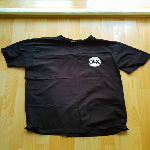

In [94]:
# Test loading an image
path = 'clothing-dataset-small/train/t-shirt/'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'

fullname = os.path.join(path, name)

img = load_img(fullname, target_size=(150, 150))

img

In [95]:
print(img)

<PIL.Image.Image image mode=RGB size=150x150 at 0x7FAE98089F40>


In [96]:
x = np.array(img)
x.shape

(150, 150, 3)

In [97]:
x

array([[[177, 168,  99],
        [178, 169, 100],
        [182, 173, 104],
        ...,
        [251, 253, 250],
        [251, 253, 248],
        [251, 253, 248]],

       [[200, 190, 129],
        [203, 193, 132],
        [203, 193, 132],
        ...,
        [250, 251, 246],
        [250, 251, 245],
        [250, 251, 245]],

       [[200, 189, 133],
        [203, 192, 136],
        [202, 191, 135],
        ...,
        [251, 250, 245],
        [250, 250, 242],
        [249, 249, 239]],

       ...,

       [[171, 157,  82],
        [170, 156,  81],
        [171, 157,  82],
        ...,
        [185, 141,  32],
        [180, 133,  25],
        [182, 135,  27]],

       [[171, 157,  82],
        [170, 156,  81],
        [171, 157,  82],
        ...,
        [187, 143,  34],
        [179, 132,  24],
        [181, 134,  26]],

       [[170, 156,  81],
        [171, 157,  82],
        [170, 156,  81],
        ...,
        [184, 138,  26],
        [182, 134,  23],
        [181, 133,  22]]

***

# Pre-tained CNN

- Imagenet dataset - https://www.image-net.org
- Pre-trained models: https://keras.io/api/applications/

we use `Xception` pre-trained model for here. 

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [31]:
model = Xception(weights='imagenet', input_shape=(150,150,3))

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (299, 299, 3).  Received: input_shape=(150, 150, 3)

In [32]:
X = np.array([x])
X = preprocess_input(X)
X[0]

NameError: name 'x' is not defined

In [33]:
pred = model.predict(X)

NameError: name 'X' is not defined

In [34]:
decode_predictions(pred)

NameError: name 'pred' is not defined

***

# Transfer Learning

- Take already trained models 
- Use Convolution layer 
- Retrain Kense layer 

## Reading data from `ImageDataGenerator`

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', 
                                              target_size=(150,150), 
                                              batch_size=32
                                             )

Found 3068 images belonging to 10 classes.


In [19]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', 
                                              target_size=(150,150), 
                                              batch_size=32,
                                              shuffle=False
                                             )

Found 341 images belonging to 10 classes.


In [20]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False


inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [21]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [23]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 12s 125ms/step - loss: 0.4566 - accuracy: 0.8576 - val_loss: 0.8486 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 12s 126ms/step - loss: 0.2447 - accuracy: 0.9120 - val_loss: 1.1266 - val_accuracy: 0.7713
Epoch 3/10
96/96 [==============================] - 12s 126ms/step - loss: 0.2088 - accuracy: 0.9276 - val_loss: 0.9009 - val_accuracy: 0.8240
Epoch 4/10
96/96 [==============================] - 12s 125ms/step - loss: 0.1496 - accuracy: 0.9478 - val_loss: 0.9825 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 12s 125ms/step - loss: 0.0869 - accuracy: 0.9690 - val_loss: 0.9592 - val_accuracy: 0.8006
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.0817 - accuracy: 0.9720 - val_loss: 1.0243 - val_accuracy: 0.7889
Epoch 7/10
96/96 [==============================] - 12s 124ms/step - loss: 0.0491 - accuracy: 0.9866 - val_loss: 1.0044 - val_accuracy: 0.8006

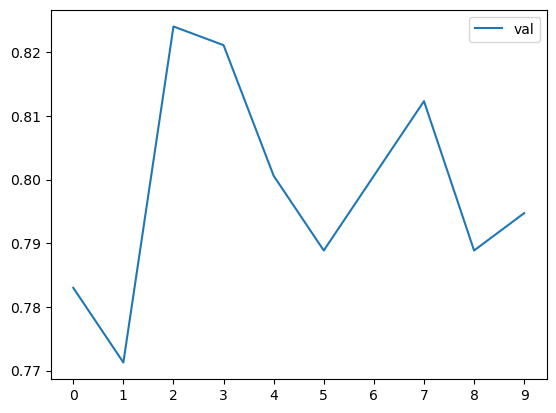

In [24]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

# Adjusting the learning rate

In [25]:
def make_model(learning_rate=0.01):
    
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False
    
    ###########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    ###########################################

    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=['accuracy'])
    
    return model 

In [26]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()  

0.0001
Epoch 1/10
96/96 [==============================] - 15s 134ms/step - loss: 1.9695 - accuracy: 0.3110 - val_loss: 1.6110 - val_accuracy: 0.4868
Epoch 2/10
96/96 [==============================] - 12s 124ms/step - loss: 1.4097 - accuracy: 0.5434 - val_loss: 1.2539 - val_accuracy: 0.5894
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 1.1607 - accuracy: 0.6343 - val_loss: 1.0656 - val_accuracy: 0.6716
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 1.0168 - accuracy: 0.6881 - val_loss: 0.9557 - val_accuracy: 0.7038
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.9206 - accuracy: 0.7083 - val_loss: 0.8803 - val_accuracy: 0.7331
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.8508 - accuracy: 0.7282 - val_loss: 0.8219 - val_accuracy: 0.7507
Epoch 7/10
96/96 [==============================] - 12s 123ms/step - loss: 0.7977 - accuracy: 0.7435 - val_loss: 0.7831 - val_accuracy:

## Plot learning rate vs accuracy

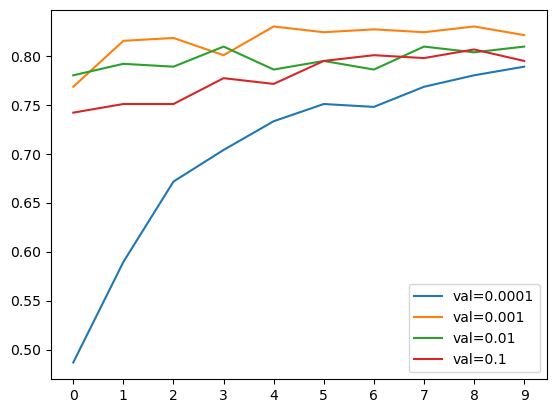

In [28]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

## Set learning rate 

In [29]:
learning_rate = 0.001

## Checkpointing

In [30]:
model.save_weights('model_v1.h5', save_format='h5')

In [31]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [32]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
96/96 [==============================] - 16s 135ms/step - loss: 1.1020 - accuracy: 0.6242 - val_loss: 0.7266 - val_accuracy: 0.7889
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.6373 - accuracy: 0.7803 - val_loss: 0.6344 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 12s 126ms/step - loss: 0.5125 - accuracy: 0.8272 - val_loss: 0.5586 - val_accuracy: 0.8182
Epoch 4/10
96/96 [==============================] - 12s 122ms/step - loss: 0.4328 - accuracy: 0.8621 - val_loss: 0.5656 - val_accuracy: 0.8065
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3772 - accuracy: 0.8862 - val_loss: 0.5587 - val_accuracy: 0.8152
Epoch 6/10
96/96 [==============================] - 12s 124ms/step - loss: 0.3286 - accuracy: 0.9058 - val_loss: 0.5351 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 12s 125ms/step - loss: 0.2908 - accuracy: 0.9188 - val_loss: 0.5235 - val_accuracy: 0.8358

# Adding more layers

In [34]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [35]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 15s 133ms/step - loss: 1.4736 - accuracy: 0.5189 - val_loss: 1.0493 - val_accuracy: 0.6628
Epoch 2/10
96/96 [==============================] - 12s 126ms/step - loss: 0.9162 - accuracy: 0.6832 - val_loss: 0.8107 - val_accuracy: 0.7185
Epoch 3/10
96/96 [==============================] - 12s 125ms/step - loss: 0.7190 - accuracy: 0.7552 - val_loss: 0.6928 - val_accuracy: 0.7947
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.6068 - accuracy: 0.8008 - val_loss: 0.6304 - val_accuracy: 0.7977
Epoch 5/10
96/96 [==============================] - 12s 124ms/step - loss: 0.5231 - accuracy: 0.8318 - val_loss: 0.6240 - val_accuracy: 0.7830
Epoch 6/10
96/96 [==============================] - 12s 125ms/step - loss: 0.4725 - accuracy: 0.8458 - val_loss: 0.6408 - val_accuracy: 0.7889
Epoch 7/10
96/96 [==============================] - 12s 124ms/step - loss: 0.4126 - accuracy: 0.8716 - val_loss: 0.5822 - val_accuracy: 0.8

## plot accuracy vs no. of dense layers

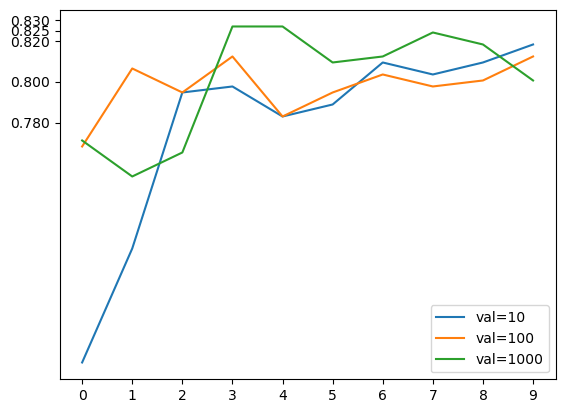

In [36]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## Regualization and dropout

In [37]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [41]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=4, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/4
96/96 [==============================] - 15s 134ms/step - loss: 0.9362 - accuracy: 0.6806 - val_loss: 0.6145 - val_accuracy: 0.8094
Epoch 2/4
96/96 [==============================] - 12s 123ms/step - loss: 0.5077 - accuracy: 0.8204 - val_loss: 0.5808 - val_accuracy: 0.8035
Epoch 3/4
96/96 [==============================] - 12s 123ms/step - loss: 0.3447 - accuracy: 0.8859 - val_loss: 0.5134 - val_accuracy: 0.8328
Epoch 4/4
96/96 [==============================] - 12s 124ms/step - loss: 0.2611 - accuracy: 0.9198 - val_loss: 0.5904 - val_accuracy: 0.8006


0.2
Epoch 1/4
96/96 [==============================] - 15s 132ms/step - loss: 1.0067 - accuracy: 0.6610 - val_loss: 0.6829 - val_accuracy: 0.7801
Epoch 2/4
96/96 [==============================] - 12s 125ms/step - loss: 0.6040 - accuracy: 0.7927 - val_loss: 0.6133 - val_accuracy: 0.7947
Epoch 3/4
96/96 [==============================] - 12s 125ms/step - loss: 0.4398 - accuracy: 0.8488 - val_loss: 0.5422 - val_accuracy: 0.8

## Plot accuracy vs drop rate 

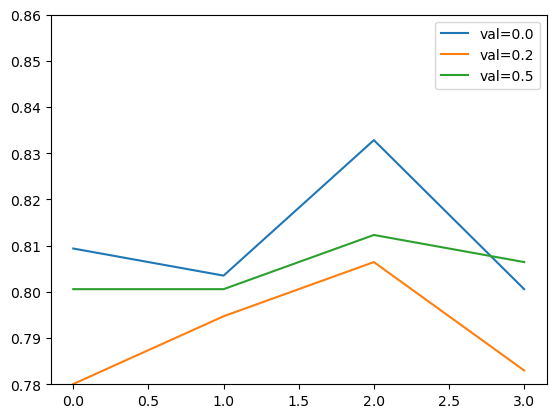

In [42]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

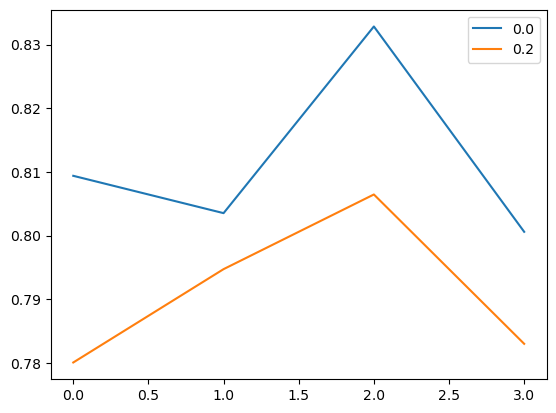

In [43]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

# Data Augmentation

In [44]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [46]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 133ms/step - loss: 1.0570 - accuracy: 0.6480 - val_loss: 0.6677 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 12s 125ms/step - loss: 0.6139 - accuracy: 0.7823 - val_loss: 0.5835 - val_accuracy: 0.8182
Epoch 3/10
96/96 [==============================] - 12s 125ms/step - loss: 0.4504 - accuracy: 0.8517 - val_loss: 0.5650 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 12s 125ms/step - loss: 0.3661 - accuracy: 0.8755 - val_loss: 0.5416 - val_accuracy: 0.8328
Epoch 5/10
96/96 [==============================] - 12s 126ms/step - loss: 0.2808 - accuracy: 0.9074 - val_loss: 0.5408 - val_accuracy: 0.8035
Epoch 6/10
96/96 [==============================] - 12s 124ms/step - loss: 0.2231 - accuracy: 0.9293 - val_loss: 0.5804 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 12s 126ms/step - loss: 0.1847 - accuracy: 0.9404 - val_loss: 0.5606 - val_accuracy: 0.8299

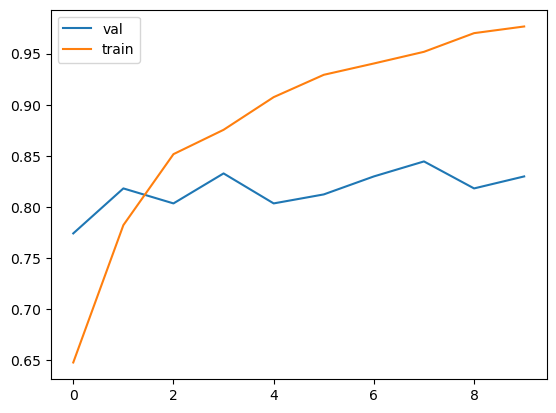

In [47]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

# Getting predictions

In [48]:
model_loaded = keras.models.load_model('xception_v1_07_0.836.h5')


In [49]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [50]:
model_loaded.evaluate(test_ds)

12/12 [==============================] - 3s 157ms/step - loss: 0.5471 - accuracy: 0.8118


[0.5471388697624207, 0.8118279576301575]

In [51]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

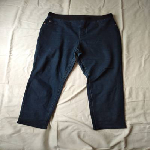

In [58]:
img = load_img(path, target_size=(150, 150))
img

In [53]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [54]:
X = preprocess_input(X)

In [55]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [56]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [57]:
dict(zip(classes, pred[0]))

{'dress': -2.6731772,
 'hat': -3.7524304,
 'longsleeve': -1.7841859,
 'outwear': -2.1085446,
 'pants': 11.37162,
 'shirt': -4.8609548,
 'shoes': -2.505327,
 'shorts': 4.6359024,
 'skirt': -5.029948,
 't-shirt': -2.8730884}